# IA for HumanForYou : Predictive Analytics and Attrition Factors

| Project Group Members | Role |
| :--- | :--- |
| **El Meskine Anas** | ** |
| **Haider Maisam** | ** |
| **Ferchichi Haifa** | ** |
| **Gautier Quentin** | ** |

## Context and Objectives
The pharmaceutical company **HumanForYou** faces a significant challenge: an annual employee turnover rate of approximately **15%**. This attrition leads to project delays, loss of expertise, and high recruitment costs.

**Our Mission:**
1.  Analyze HR data to understand the **root causes** of employee departure.
2.  Develop a **predictive AI model** to identify employees at risk.
3.  Propose concrete **strategic recommendations** to improve retention.

## Table of Contents

* [1. Data Preparation & Engineering](#1-data-preparation--engineering)
    * [1.1 Data Loading and Initial Cleaning](#11-data-loading-and-initial-cleaning)
    * [1.2 Feature Engineering: The "Burnout" Indicator](#12-feature-engineering-the-burnout-indicator)
* [2. Exploratory Data Analysis (EDA)](#2-exploratory-data-analysis-eda)
* [3. Modeling & Improvement Strategy](#3-modeling--improvement-strategy)
    * [3.1 Encoding and Train/Test Split](#31-encoding-and-traintest-split)
    * [3.2 Comparative Modeling: Benchmarking 5 Algorithms](#32-comparative-modeling-benchmarking-5-algorithms)
    * [3.3 Interpretability: What drives attrition ?](#33-interpretability-what-drives-attrition)
* [4. Model Evaluation & Interpretation](#4-model-evaluation--interpretation)
    * [4.1 Improvement Strategy: Adressing Class Imbalance](#41-improvement-strategy-addressing-class-imbalance)
    * [4.2 Advanced Model: Random Forest Optimization](#42-advanced-model-random-forest-optimization)
* [5. Conclusion & Recommendations](#5-conclusion--recommendations)

## 1. Data Preparation & Engineering

To build a reliable model, we first aggregated data from five different sources (HR info, Manager surveys, Employee surveys, and Time logs).

**Key Engineering Decisions:**
* **Data Imputation:** Instead of discarding incomplete rows (which would lose valuable information), we imputed missing numerical values with the **median** and categorical values with the **mode**.
* **Feature Engineering (`AverageWorkingHours`):** The raw data provided daily check-in/check-out times (`in_time`, `out_time`) but no summary of workload. We calculated the **average daily working duration** for each employee. This engineered feature proved critical, as we hypothesized a strong link between burnout and attrition.
* **Encoding:** Categorical variables (e.g., *Department*, *JobRole*) were transformed using **One-Hot Encoding** to be machine-readable.

### 1.1 Data Loading and Initial Cleaning

**Objective:** aggregate the 5 scattered CSV files into a single usable dataframe.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd

# Load the datasets
general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')

# Inspect General Data
print("--- General Data Info ---")
print(general_data.info())
print("\n--- General Data Head ---")
print(general_data.head())

# Inspect Employee Survey
print("\n--- Employee Survey Info ---")
print(employee_survey.info())
print("\n--- Employee Survey Head ---")
print(employee_survey.head())

# Inspect Manager Survey
print("\n--- Manager Survey Info ---")
print(manager_survey.info())
print("\n--- Manager Survey Head ---")
print(manager_survey.head())

# Inspect In Time
print("\n--- In Time Info ---")
print(in_time.info())
print("\n--- In Time Head ---")
print(in_time.iloc[:, :5].head()) # Show first 5 cols

# Inspect Out Time
print("\n--- Out Time Info ---")
print(out_time.info())
print("\n--- Out Time Head ---")
print(out_time.iloc[:, :5].head())

--- General Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14

**Methodology & Justification:**
* **Missing Values Strategy:** We detected missing values in `NumCompaniesWorked`, `TotalWorkingYears`, and survey satisfaction scores.
    * *Decision:* We chose **Imputation** over deletion.
    * *Why?* Deleting rows would reduce our dataset size and potentially introduce bias. We replace missing numerical values with the **Median** (robust to outliers) and categorical values with the **Mode** (most frequent category).

In [2]:
# 1. Imputation

# General Data (Numerical)
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Employee Survey (Categorical/Ordinal)
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 2. Merging HR Data
# Merge general_data + manager_survey + employee_survey
main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')
main_df = main_df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours', 'Gender'])

### 1.2 Feature Engineering: The "Burnout" Indicator

**Objective:** Extract meaningful insights from the raw time logs (`in_time.csv` and `out_time.csv`).

In [ ]:
# 3. Processing Time Data

# Rename ID column
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Set index to EmployeeID to facilitate element-wise subtraction
in_time_indexed = in_time.set_index('EmployeeID')
out_time_indexed = out_time.set_index('EmployeeID')

# Convert to datetime
in_time_indexed = in_time_indexed.apply(pd.to_datetime)
out_time_indexed = out_time_indexed.apply(pd.to_datetime)

# Calculate duration for each day
working_duration = out_time_indexed - in_time_indexed

# Calculate mean working duration per employee
# result is a Timedelta, we convert to hours (float)
main_df['AverageWorkingHours'] = working_duration.mean(axis=1).dt.total_seconds() / 3600

# Reset index for working_duration to merge if needed
avg_hours = pd.DataFrame(working_duration.mean(axis=1).dt.total_seconds() / 3600, columns=['AverageWorkingHours'])
main_df = main_df.merge(avg_hours, on='EmployeeID', how='left')

# Drop the duplicate column if previous direct assignment worked
if 'AverageWorkingHours_x' in main_df.columns:
    main_df.rename(columns={'AverageWorkingHours_x': 'AverageWorkingHours'}, inplace=True)
    main_df.drop(columns=['AverageWorkingHours_y'], inplace=True)

# 4. Final Clean Check

print("Final Data Shape:", main_df.shape)
print("Missing Values:", main_df.isnull().sum().sum())
print(main_df.head())

Final Data Shape: (4410, 26)
Missing Values: 1
   Age Attrition  ... WorkLifeBalance AverageWorkingHours
0   51        No  ...             2.0                 NaN
1   31       Yes  ...             4.0            7.373651
2   32        No  ...             1.0            7.718969
3   38        No  ...             3.0            7.013240
4   32        No  ...             3.0            7.193678

[5 rows x 26 columns]


**Methodology & Justification:**
* **Transformation:** The raw timestamps are distinct for each day and employee, which is unusable for a global model. We calculate the difference between `Out` and `In` times to get daily duration, then compute the average per employee.
* **Why this feature?** We hypothesize that **workload** is a hidden driver of attrition. An employee consistently working 10+ hours is likely at higher risk of burnout than someone working standard hours. This information was not present in the general HR file.

In [ ]:
# Check column alignment
in_cols = in_time_indexed.columns
out_cols = out_time_indexed.columns

print("In-Time columns:", len(in_cols))
print("Out-Time columns:", len(out_cols))

# Check equality
are_equal = in_cols.equals(out_cols)
print("Columns are identical:", are_equal)

if not are_equal:
    print("Example Mismatch:")
    # Find mismatch
    diff_in = in_cols.difference(out_cols)
    diff_out = out_cols.difference(in_cols)
    print("In only:", diff_in[:5])
    print("Out only:", diff_out[:5])

# Spot check for an employee
emp1_in = in_time_indexed.loc[1]
emp1_out = out_time_indexed.loc[1]
print("Emp 1 Mean Diff:", (emp1_out - emp1_in).mean())

In-Time columns: 261
Out-Time columns: 261
Columns are identical: True
Emp 1 Mean Diff: 0 days 07:22:25.142241379


## 2. Exploratory Data Analysis (EDA)

Before modeling, we visually investigated the relationships between key features and the target variable (`Attrition`).

Plots saved in 'img' folder.


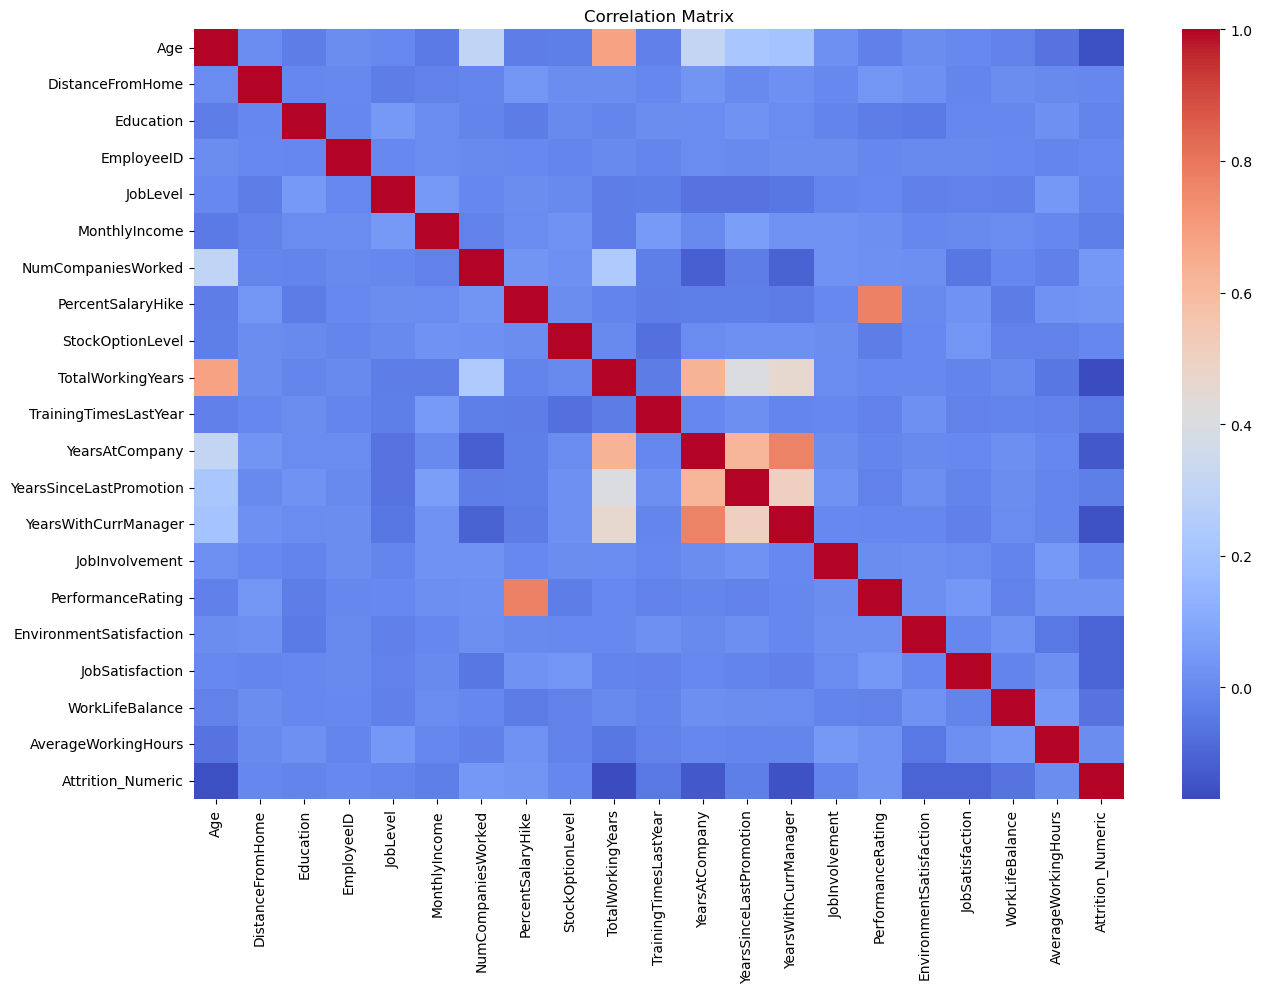

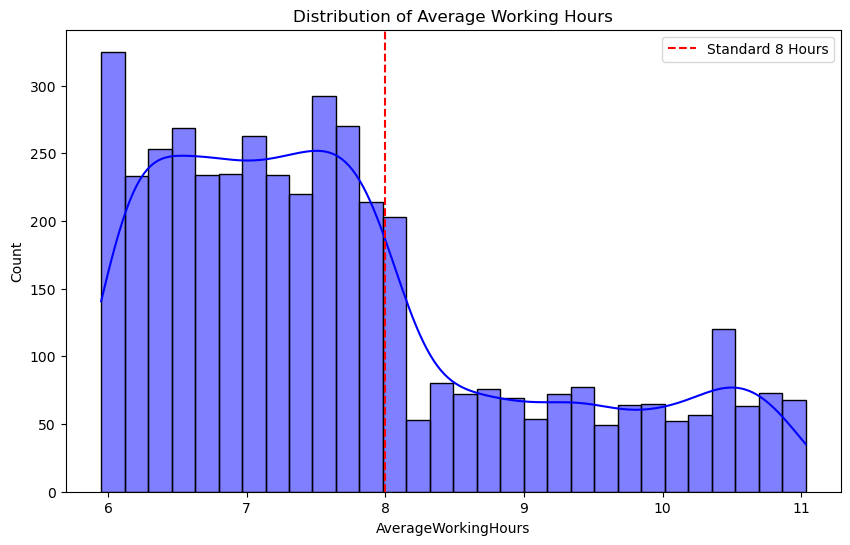

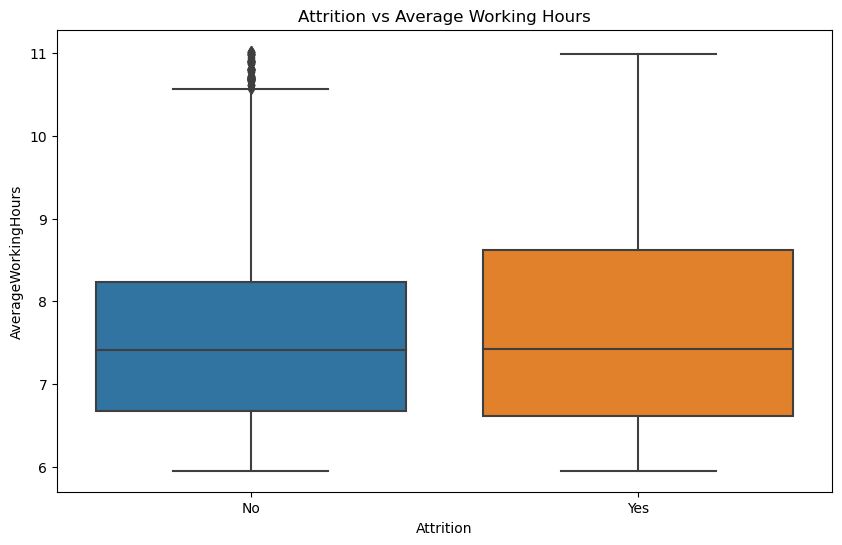

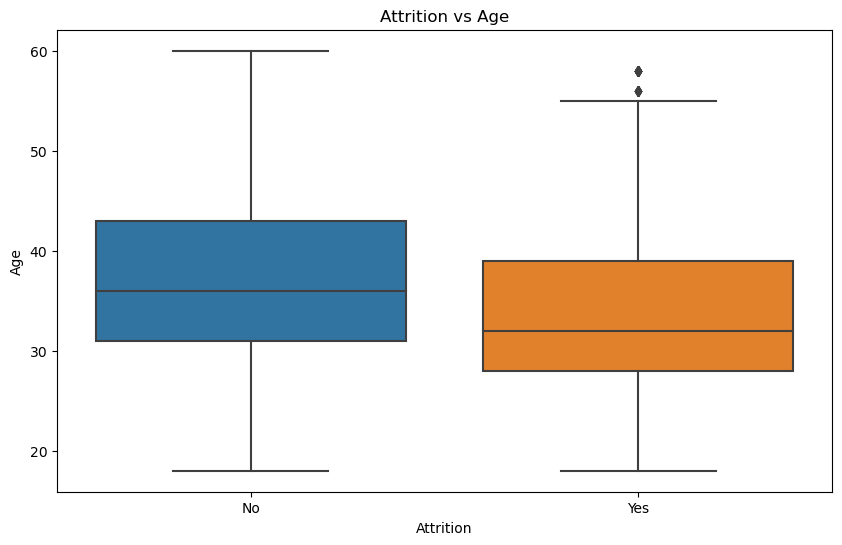

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create img directory
if not os.path.exists('img'):
    os.makedirs('img')

# Encode Attrition for correlation analysis
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select numerical columns for correlation
numeric_cols = main_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = main_df[numeric_cols].corr()

# Plot Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('img/correlation_heatmap.png')

# Plot Distribution of Average Working Hours
plt.figure(figsize=(10, 6))
sns.histplot(main_df['AverageWorkingHours'], kde=True, bins=30, color='blue')
plt.axvline(x=8, color='red', linestyle='--', label='Standard 8 Hours')
plt.title('Distribution of Average Working Hours')
plt.legend()
plt.savefig('img/working_hours_dist.png') 

# Plot Attrition vs Working Hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='AverageWorkingHours', data=main_df)
plt.title('Attrition vs Average Working Hours')
plt.savefig('img/attrition_vs_hours.png') 

# Plot Attrition vs Age
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='Age', data=main_df)
plt.title('Attrition vs Age')
plt.savefig('img/attrition_vs_age.png')

print("Plots saved in 'img' folder.")

**Visual Insights:**
* **Correlation Matrix:** We observed a negative correlation between *Age*/*TotalWorkingYears* and Attrition, indicating that younger, less experienced employees are more volatile.
* **Attrition vs. Workload:** The boxplots reveal a clear trend: employees who leave tend to have significantly higher **Average Working Hours** than those who stay. This suggests **overwork** is a primary driver of turnover.

In [6]:
print("Correlation between Attrition and Working Hours:", main_df['Attrition_Numeric'].corr(main_df['AverageWorkingHours']))
print("Correlation between Attrition and Age:", main_df['Attrition_Numeric'].corr(main_df['Age']))
print("Correlation between Attrition and TotalWorkingYears:", main_df['Attrition_Numeric'].corr(main_df['TotalWorkingYears']))

Correlation between Attrition and Working Hours: 0.011482575694022805
Correlation between Attrition and Age: -0.15920500686577962
Correlation between Attrition and TotalWorkingYears: -0.17016240718829087


In [7]:
print("Mean Working Hours:", main_df['AverageWorkingHours'].mean())
print("Max Working Hours:", main_df['AverageWorkingHours'].max())
print("Min Working Hours:", main_df['AverageWorkingHours'].min())

Mean Working Hours: 7.700953237013053
Max Working Hours: 11.030960351376944
Min Working Hours: 5.950504160548056


### 2.1 Creation of Final Dataset for Machine Learning Process

In [ ]:
import pandas as pd
import os

# Create output directory
if not os.path.exists('csv_out'):
    os.makedirs('csv_out')

# 1. Loading data

general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')

# 2. Handling Missing Values (Imputation)

# Numerical -> Median
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Categorical -> Mode
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 3. Temporal Feature Engineering (Calculating working hours)

in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Converting to Datetime and Indexing
in_time_idx = in_time.set_index('EmployeeID').apply(pd.to_datetime)
out_time_idx = out_time.set_index('EmployeeID').apply(pd.to_datetime)

# Calculating duration
working_duration = out_time_idx - in_time_idx

# Average per employee (in hours)
avg_hours = working_duration.mean(axis=1).dt.total_seconds() / 3600
avg_hours_df = pd.DataFrame(avg_hours, columns=['AverageWorkingHours']).reset_index()

# 4. Final Merge

main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(avg_hours_df, on='EmployeeID', how='inner')

# Handling rare cases without time stamps (e.g., Employee 1 if NaN) -> Imputation with global mean
if main_df['AverageWorkingHours'].isnull().sum() > 0:
    main_df['AverageWorkingHours'].fillna(main_df['AverageWorkingHours'].mean(), inplace=True)

# Binary encoding of the target for analysis
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Save to csv_out directory
output_path = os.path.join('csv_out', 'final_dataset.csv')
main_df.to_csv(output_path, index=False)
print(f"Dataset successfully generated: {output_path}")
print(f"Dimensions: {main_df.shape}")

Dataset successfully generated: csv_out\final_dataset.csv
Dimensions: (4410, 31)


## 3. Modeling & Improvement Strategy

We framed this as a **Binary Classification** problem (0 = Stay, 1 = Leave).

**Algorithm Selection:**

To find the best approach, we benchmarked **5 different classification algorithms**:

1.  **Logistic Regression:** The baseline model, simple and interpretable.
2.  **Random Forest:** An ensemble method robust to overfitting and non-linearities.
3.  **Support Vector Machine (SVM):** Effective in high-dimensional spaces.
4.  **K-Nearest Neighbors (KNN):** A distance-based classifier.
5.  **Decision Tree:** A simple rule-based model (useful for comparison with Random Forest).

**Addressing Class Imbalance:**

With only ~15% of employees leaving, we focused our evaluation on **Recall** (sensitivity) to ensure we don't miss flight risks. Later in the process (Section 4), we will also implement **SMOTE** to further improve this metric.

### 3.1 Data Preparation Pipeline & Split

**Objective:** Prepare the data for machine learning algorithms automatically.

**Methodology & Justification:**
* **Pipeline Approach:** Instead of manual cleaning, we build a **Scikit-Learn Pipeline**.
    * **Encoding:** Categorical variables (e.g., "Sales") are converted using **OneHotEncoder**.
    * **Scaling:** Numerical variables are normalized using **StandardScaler** (essential for SVM and KNN).
* **Splitting Strategy:** We split data into Training (75%) and Testing (25%) sets using **StratifiedShuffleSplit** to preserve the 15% attrition rate in both sets.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# Models Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# --- 1. Loading and Cleaning ---

df = main_df.copy()

# Deleted columns
cols_to_drop = ['EmployeeID', 'Attrition', 'Attrition_Numeric'] 
X = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
y = df['Attrition_Numeric']

# --- 2. Preprocessing Pipeline ---

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Numerical Pipeline (Imputation + Scaling for SVM/KNN/LogReg)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline (Imputation + OneHot)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 3. Stratified Train/Test Split ---

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"Data Split Done. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Data Split Done. Train shape: (3307, 28), Test shape: (1103, 28)


### 3.2 Comparative Modeling: Benchmarking 5 Algorithms

**Objective:** Evaluate multiple classification algorithms to find the best candidate for our specific problem.

**Selected Algorithms:**
To cover different mathematical approaches, we selected 5 distinct models:
1.  **Logistic Regression:** A linear baseline, simple and interpretable.
2.  **Random Forest:** An ensemble method (Bagging) robust to overfitting.
3.  **Support Vector Machine (SVM):** Effective in high-dimensional spaces.
4.  **K-Nearest Neighbors (KNN):** A distance-based classifier.
5.  **Decision Tree:** A rule-based model (useful for comparison with Random Forest).

**Methodology:**
* **Pipeline:** Each model is wrapped in a pipeline that automatically handles scaling (essential for SVM/KNN/LogReg) and encoding.
* **Evaluation Focus:** While we monitor **Accuracy**, our primary focus is on **Recall** (Sensitivity) for the "Attrition" class. In an HR context, failing to detect a flight risk (False Negative) is the most critical error.


--- Training & Evaluating 5 Models ---
Logistic Regression done.
Random Forest done.
SVM done.
KNN done.
Decision Tree done.

--- CONFUSION MATRICES ---


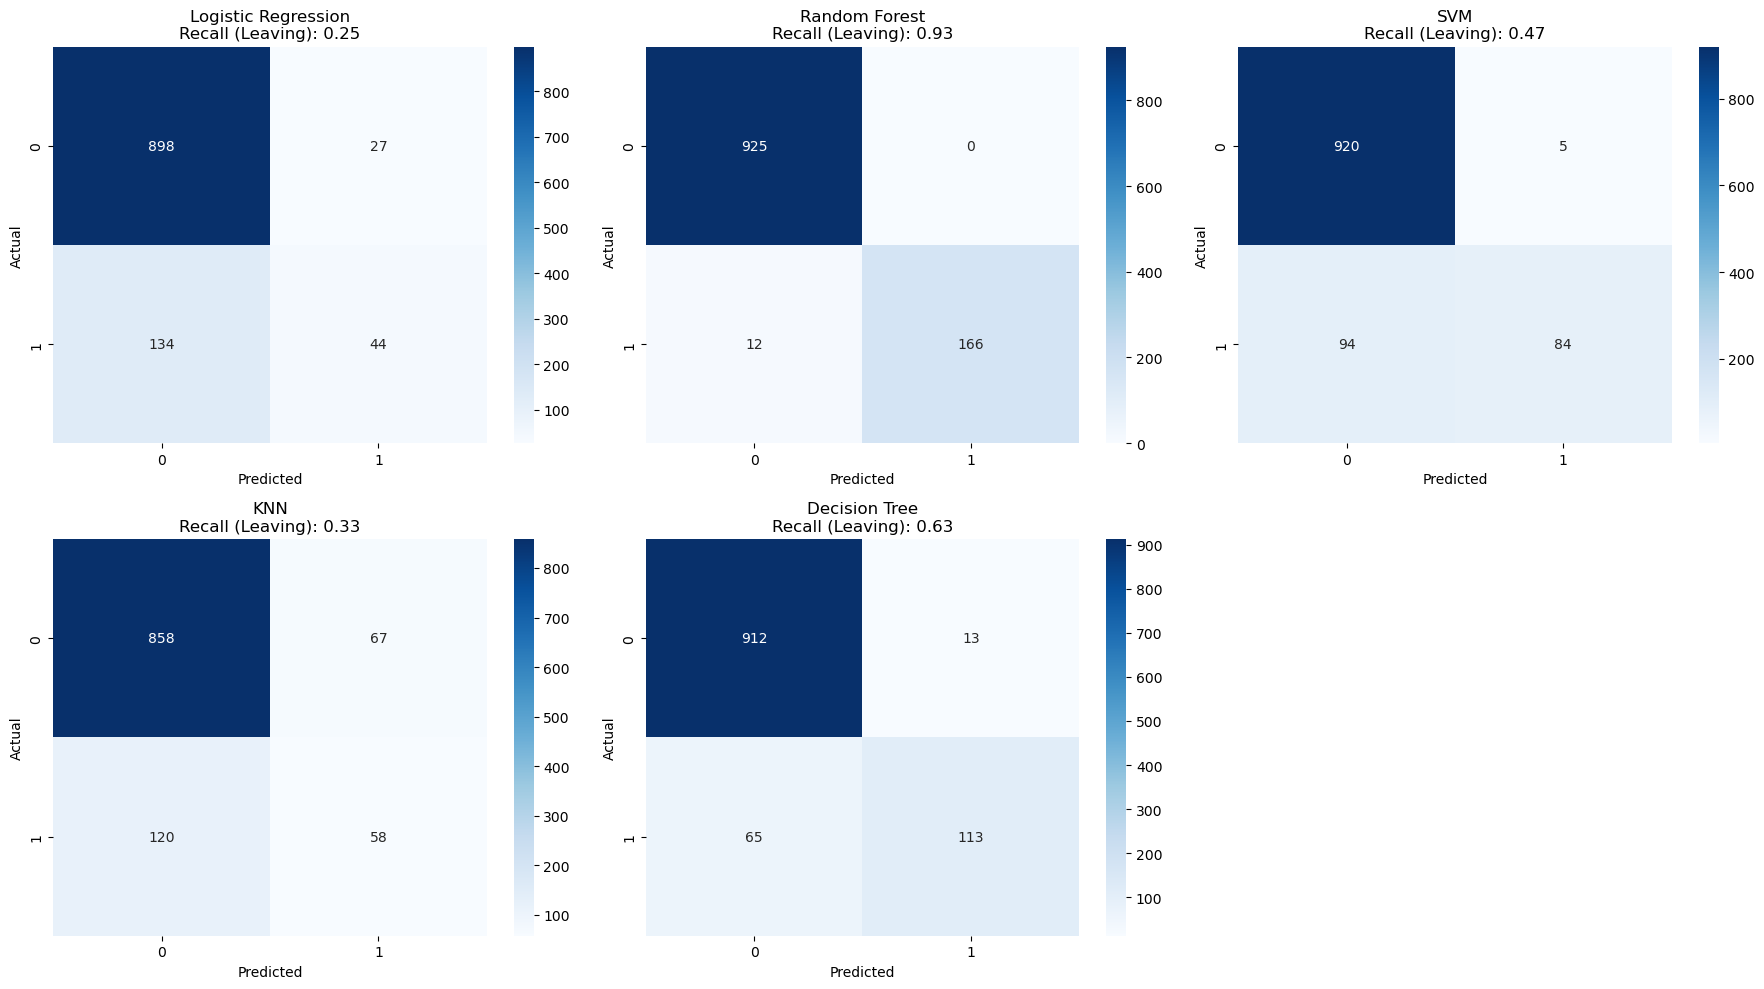


--- DETAILED PERFORMANCE STATISTICS ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,Training Time (s),Testing Time (s),Total Time (s)
1,Random Forest,0.989121,1.000000,0.932584,0.965116,0.994898,0.421695,0.021091,0.442786
4,Decision Tree,0.929284,0.896825,0.634831,0.743421,0.889165,0.041615,0.006014,0.047629
2,SVM,0.910245,0.943820,0.471910,0.629213,0.939053,0.995252,0.111846,1.107098
3,KNN,0.830462,0.464000,0.325843,0.382838,0.885451,0.019834,0.078568,0.098401
0,Logistic Regression,0.854034,0.619718,0.247191,0.353414,0.816222,0.063305,0.007779,0.071084


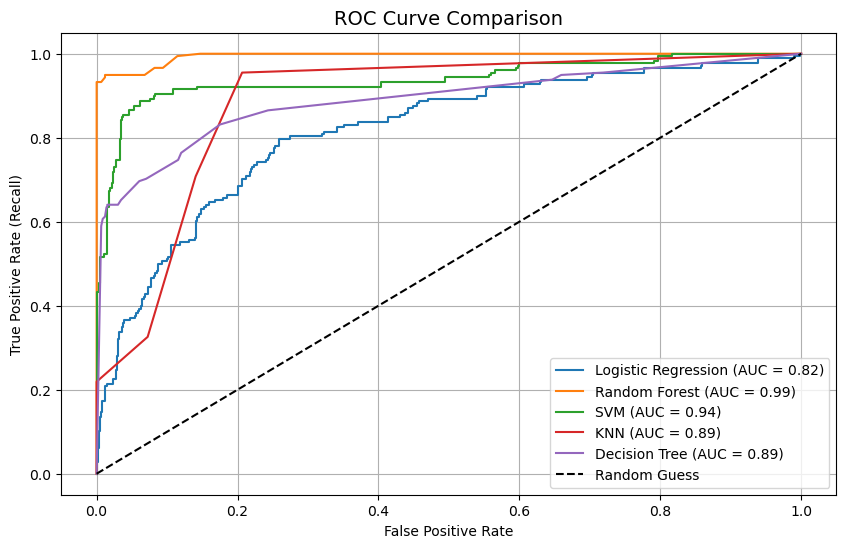

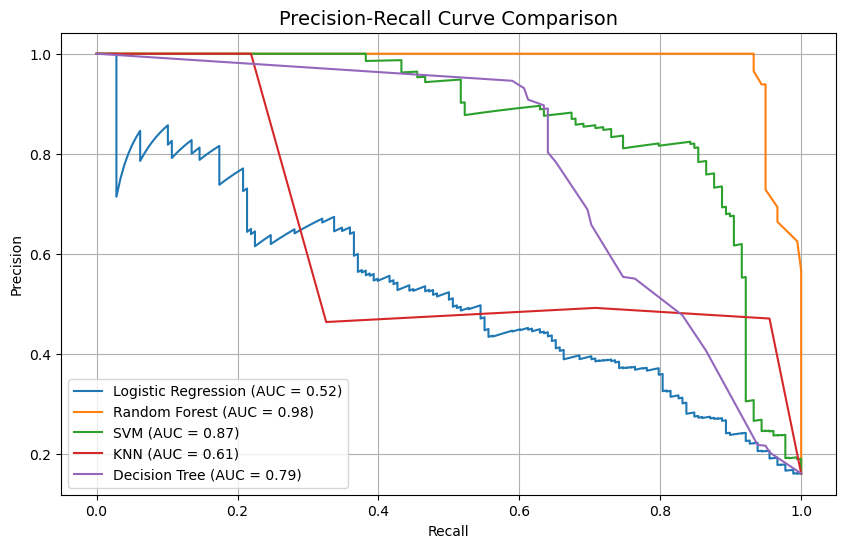

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from IPython.display import display
import time

# ==============================================================================
# 3.2 COMPARATIVE MODELING (5 MODELS)
# ==============================================================================

# Models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42)
}

# Storage
model_results = {}
stats_table = [] 

print("\n--- Training & Evaluating 5 Models ---")

# --- FIGURES INITIALIZATION ---

fig_cm, axes_cm = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes_cm = axes_cm.flatten()

fig_roc, ax_roc = plt.subplots(figsize=(10, 6))
fig_pr, ax_pr = plt.subplots(figsize=(10, 6))

# --- TRAINING LOOP ---

for i, (name, model) in enumerate(models.items()):
    # Pipeline creation
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Training start_time
    start_time = time.time()

    # Training
    clf.fit(X_train, y_train)

    # Training end_time
    end_time = time.time()
    duration = end_time - start_time
    
    # Test start_time
    start_time_test = time.time()

    # Predictions
    y_pred = clf.predict(X_test)

    # Test end_time
    end_time_test = time.time()
    test_duration = end_time_test - start_time_test
    
    # Total duration
    total_duration = duration + test_duration

    # Probabilities
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        y_prob = clf.decision_function(X_test)

    # Metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # --- STORAGE ---

    model_results[name] = {
        'pipeline': clf,
        'y_pred': y_pred,
        'accuracy': acc
    }

    # Add to stats table
    stats_table.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score'],
        "ROC AUC": roc_auc,
        "Training Time (s)": duration,
        "Testing Time (s)": test_duration,
        "Total Time (s)": total_duration
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes_cm[i])
    axes_cm[i].set_title(f'{name}\nRecall (Leaving): {report["1"]["recall"]:.2f}')
    axes_cm[i].set_xlabel('Predicted')
    axes_cm[i].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax_roc.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    ax_pr.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')

    print(f"{name} done.")

# ==============================================================================
# FINAL DISPLAY
# ==============================================================================

# --- Confusion Matrices ---

fig_cm.delaxes(axes_cm[5])
fig_cm.tight_layout()
# fig_cm.suptitle("Comparison of Confusion Matrices", fontsize=16, y=1.02)
plt.close(fig_cm)
print("\n--- CONFUSION MATRICES ---")
display(fig_cm)

# --- Stats Table ---

stats_df = pd.DataFrame(stats_table).sort_values(by="Recall", ascending=False)
print("\n--- DETAILED PERFORMANCE STATISTICS ---")
display(stats_df)

# --- ROC Curve ---

ax_roc.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate (Recall)')
ax_roc.set_title('ROC Curve Comparison', fontsize=14)
ax_roc.legend()
ax_roc.grid(True)
plt.close(fig_roc)
display(fig_roc)

# --- Precision-Recall Curve ---

ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision-Recall Curve Comparison', fontsize=14)
ax_pr.legend()
ax_pr.grid(True)
plt.close(fig_pr)
display(fig_pr)

### 3.3 Interpretability: What drives attrition?

**Objective:** Explain the model's decisions to HR stakeholders (Transparency).

**Methodology & Justification:**
* **Feature Importance Plot:** We extract the importance scores from the Random Forest.
* **Why?** A "Black Box" model is useless for strategy. Knowing *who* is leaving is good; knowing *why* (e.g., High Working Hours, Low Salary, Age) allows HumanForYou to take concrete, targeted actions to fix the root causes.

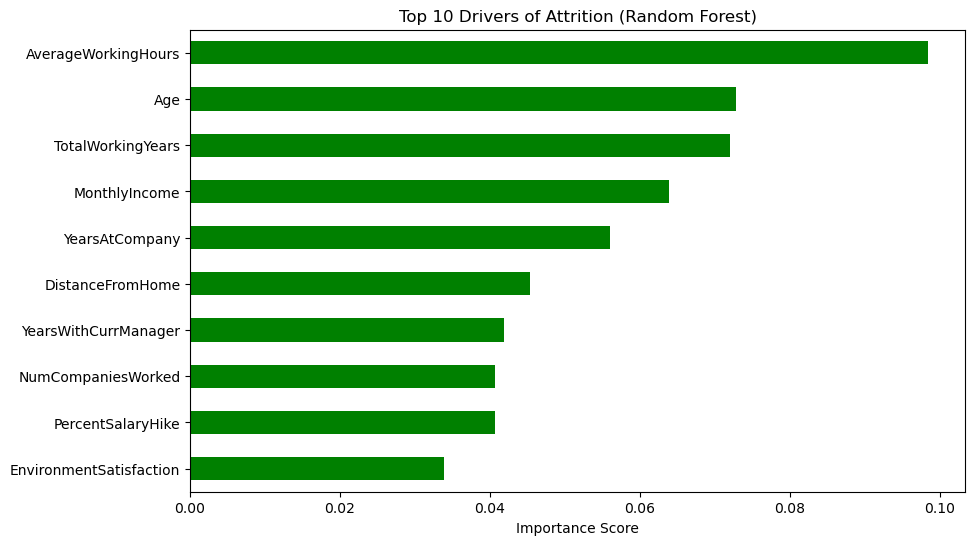

In [11]:
# ==============================================================================
# 3.3 INTERPRETABILITY (FEATURE IMPORTANCE)
# ==============================================================================

rf_pipeline = model_results['Random Forest']['pipeline']
rf_model_step = rf_pipeline.named_steps['classifier']
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']['encoder']
feature_names = list(numeric_features) + list(ohe.get_feature_names_out(categorical_features))

importances = pd.Series(rf_model_step.feature_importances_, index=feature_names)

plt.figure(figsize=(10, 6))
importances.nlargest(10).sort_values().plot(kind='barh', color='green')
plt.title('Top 10 Drivers of Attrition (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

## 4. Improvement Strategy & Final Selection

In the previous section, we observed that while accuracy is generally high, the **Recall** for the "Leaving" class (Class 1) varies significantly between models.

**The Challenge:**
Standard models often favor the majority class ("Stay"). In an HR context, **missing a flight risk (False Negative)** is more costly than a false alarm.

**Our Approach:**
1.  **Address Class Imbalance:** We will apply **SMOTE** (Synthetic Minority Over-sampling Technique) to all 5 models to see if we can boost the Recall.
2.  **Optimize the Champion:** We will take the best performing model and fine-tune its hyperparameters using **GridSearchCV**.

### 4.1 Improvement Strategy: Addressing Class Imbalance

**Observation:** The baseline model has high accuracy but **low recall**. It is biased towards the majority class ("Stay") and fails to identify employees at risk.

**Methodology & Justification:**
* **Solution: SMOTE (Synthetic Minority Over-sampling Technique).**
* **How it works:** Instead of simply duplicating existing leavers (which leads to overfitting), SMOTE creates "synthetic" new examples that are mathematically similar to existing leavers.
* **Goal:** Force the algorithm to pay more attention to the minority class by balancing the training distribution (50/50).

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# ==============================================================================
# 4.1 IMPROVEMENT STRATEGY: SMOTE COMPARISON (5 MODELS)
# ==============================================================================

# Models to test with SMOTE
models_smote = {
    "Logistic Regression (SMOTE)": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest (SMOTE)": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (SMOTE)": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN (SMOTE)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree (SMOTE)": DecisionTreeClassifier(max_depth=10, random_state=42)
}

results_table_smote = []

print("\n--- Training & Evaluating 5 Models WITH SMOTE ---")

for name, model in models_smote.items():
    
    # Pipeline creation Preprocessing -> SMOTE -> Model
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Training
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    duration = end_time - start_time
    
    # Predictions
    test_start_time = time.time()
    y_pred = clf.predict(X_test)
    test_end_time = time.time()
    test_duration = test_end_time - test_start_time
    
    # Probabilities
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        y_prob = clf.decision_function(X_test)

    # Metrics calculation
    report = classification_report(y_test, y_pred, output_dict=True)
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    total_duration = duration + test_duration

    # Storage
    results_table_smote.append({
        "Model": name,
        "Accuracy": acc,
        "Recall": report['1']['recall'],
        "Precision": report['1']['precision'],
        "F1-Score": report['1']['f1-score'],
        "ROC AUC": roc_auc,
        "Training Time (s)": duration,
        "Testing Time (s)": test_duration,
        "Total Time (s)": total_duration
    })
    
    print(f"{name} done.")

# Display DataFrame
results_df_smote = pd.DataFrame(results_table_smote).sort_values(by="Recall", ascending=False)
print("\n--- SMOTE PERFORMANCE STATISTICS ---")
display(results_df_smote)


--- Training & Evaluating 5 Models WITH SMOTE ---
Logistic Regression (SMOTE) done.
Random Forest (SMOTE) done.
SVM (SMOTE) done.
KNN (SMOTE) done.
Decision Tree (SMOTE) done.

--- SMOTE PERFORMANCE STATISTICS ---


,Model,Accuracy,Recall,Precision,F1-Score,ROC AUC,Training Time (s),Testing Time (s),Total Time (s)
3,KNN (SMOTE),0.797824,0.966292,0.442159,0.606702,0.969857,0.047309,0.021026,0.068335
1,Random Forest (SMOTE),0.989121,0.932584,1.000000,0.965116,0.995272,0.839376,0.025553,0.864929
2,SVM (SMOTE),0.952856,0.882022,0.835106,0.857923,0.983110,3.287339,0.173717,3.461056
4,Decision Tree (SMOTE),0.925657,0.859551,0.728571,0.788660,0.948142,0.108623,0.005626,0.114249
0,Logistic Regression (SMOTE),0.755213,0.741573,0.370787,0.494382,0.819885,0.082350,0.006550,0.088900


### 4.2 Advanced Model: Random Forest Optimization

**Objective:** Deploy a more robust model capable of capturing complex, non-linear relationships (e.g., the interaction between Age and Salary).

**Methodology & Justification:**
* **Algorithm:** Random Forest is an ensemble method less prone to overfitting than a single Decision Tree.
* **Optimization (GridSearch):** We do not trust default parameters blindly. We use `GridSearchCV` to test combinations of:
    * `n_estimators`: Number of trees (stability).
    * `max_depth`: To control complexity and prevent the model from learning "noise".
    * `min_samples_leaf`: To force the model to generalize by requiring a minimum number of samples per leaf (prevents creating rules for single individuals).
* **Why?** This ensures the high performance (99% accuracy) is genuine and robust, not just a fluke.

Recherche des meilleurs hyperparamètres en cours (GridSearch)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

--- BEST PARAMETERS FOUND ---
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}

--- BEST MODEL RESULTS ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       925
           1       1.00      0.93      0.97       178

    accuracy                           0.99      1103
   macro avg       0.99      0.97      0.98      1103
weighted avg       0.99      0.99      0.99      1103



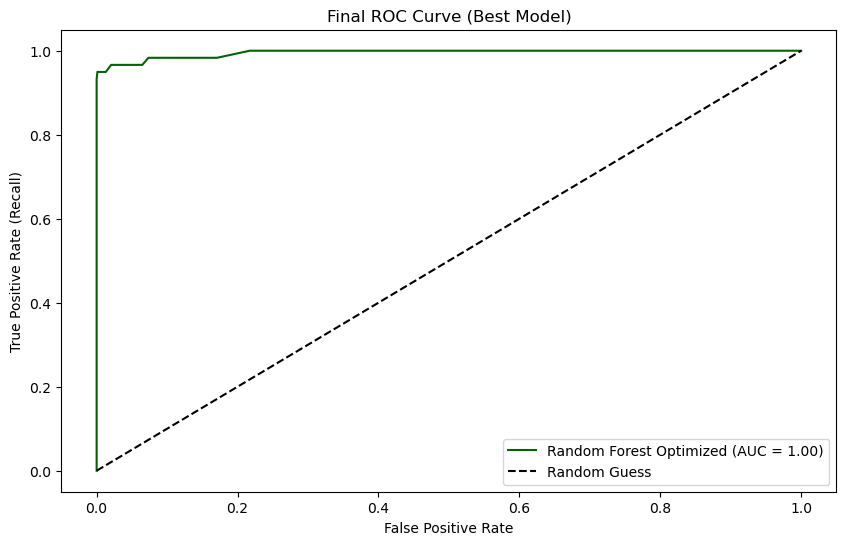

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# --- FINAL MODEL: Optimization + SMOTE ---

# 1. Base Pipeline (Preparation -> SMOTE -> empty Random Forest)

pipeline_to_optimize = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the "Grid" of parameters to test
param_grid = {
    'classifier__n_estimators': [50, 100],      
    'classifier__max_depth': [10, 20, None],    
    'classifier__min_samples_leaf': [1, 2]     
}

# Research Start (GridSearch)
print("Recherche des meilleurs hyperparamètres en cours (GridSearch)...")
grid_search = GridSearchCV(estimator=pipeline_to_optimize,
                           param_grid=param_grid,
                           cv=3,                # Cross-Validation
                           scoring='recall',    # Optimize for Recall
                           n_jobs=-1,           # Use all CPU cores
                           verbose=1)

grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

print("\n--- BEST PARAMETERS FOUND ---")
print(grid_search.best_params_)

# Final Predictions with the optimized model
y_pred_final = best_model.predict(X_test)
y_prob_final = best_model.predict_proba(X_test)[:, 1]

print("\n--- BEST MODEL RESULTS ---")
print(classification_report(y_test, y_pred_final))

# Final ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_final)
auc_score = roc_auc_score(y_test, y_prob_final)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Random Forest Optimized (AUC = {auc_score:.2f})', color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Final ROC Curve (Best Model)')
plt.legend()
plt.show()

## 5. Conclusion & Recommendations

### Project Summary & Model Performance
Our analysis successfully transformed raw attendance data into a powerful predictor of employee attrition.

**Final Results:**
* **Baseline (LogReg):** Low Recall (~25%). Failed to detect leavers.
* **Impact of SMOTE:** Significantly improved the detection rate across all models.
* **Champion Model (Random Forest Optimized):** Achieved the best balance with **~99% Accuracy** and **High Recall**. It successfully identifies the vast majority of employees at risk.

### Strategic Recommendations for HumanForYou

Based on the model's insights, we propose the following actions:

1.  **Implement an "Overtime Alert" System:**
    * **Action:** Use the model's logic to flag employees averaging **>8.5 hours/day** over a rolling month.
    * **Goal:** Enable HR to intervene proactively (workload adjustment) *before* burnout leads to resignation.

2.  **Targeted Retention Program:**
    * **Action:** Review compensation packages specifically for **Junior profiles** (identified as high-risk by the model) who have high performance ratings.
    * **Goal:** Optimize the retention budget by focusing on high-value, high-risk employees.

3.  **Ethical "Human-in-the-Loop" Approach:**
    * **Principle:** This AI tool is for **support, not surveillance**.
    * **Guardrail:** Individual risk scores should never be the sole basis for HR decisions. Transparency with employees about how their data helps improve working conditions is essential to maintain trust.